In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Field Generation

(np.float64(0.0), np.float64(100.0), np.float64(0.0), np.float64(100.0))

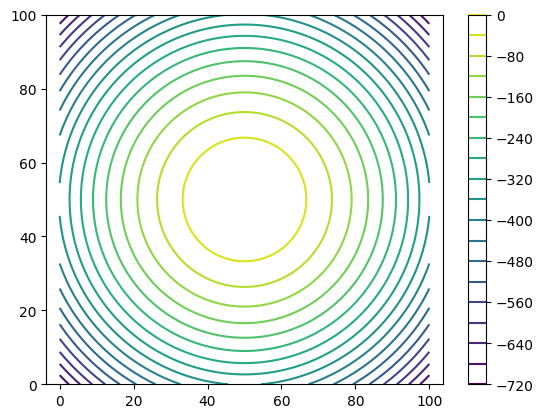

In [2]:
width=500

x_circ = np.linspace(-width // 2, width // 2, 101)  
y_circ = np.linspace(-width // 2, width // 2, 101)
X_circ, Y_circ = np.meshgrid(x_circ, y_circ)

x0_circ, y0_circ = 0, 0

A = -2/350
Psi_circ = A*( (X_circ-x0_circ)**2 + (Y_circ-y0_circ)**2 )

u_circ, v_circ = (-2*A*(Y_circ - y0_circ)).T, (2*A*(X_circ - x0_circ)).T

plt.contour(Psi_circ, 20)
plt.colorbar()
plt.axis('equal')

(np.float64(-250.0), np.float64(250.0), np.float64(-250.0), np.float64(250.0))

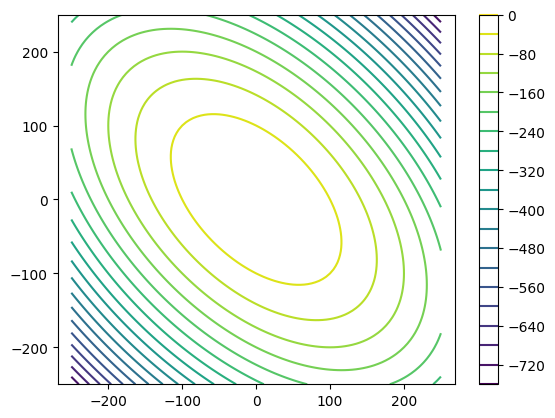

In [3]:
width=500

x_ell = np.linspace(-width // 2, width // 2, 101)  
y_ell = np.linspace(-width // 2, width // 2, 101) 
X_ell, Y_ell = np.meshgrid(x_ell, y_ell)

x0_ell, y0_ell = 0, 0

q11, q22, q12 = 2, 2, 1
A = -1/500
q11 *= A
q22 *= A
q12 *= A
Q = np.array([[q11, q12], [q12, q22]])

XY = np.stack((X_ell, Y_ell), axis=-1)  # Shape (101, 101, 2)
Psi_ell = np.einsum("...i,ij,...j->...", XY, Q, XY)

u_ell = (-2*q22*(Y_ell-y0_ell) - 2*q12*(X_ell-x0_ell)).T
v_ell =  (2*q11*(X_ell-x0_ell) + 2*q12*(Y_ell-y0_ell)).T

plt.contour(X_ell, Y_ell, Psi_ell, 20)
plt.colorbar()
plt.axis('equal')

## MOCAspace

$$
\Psi(x,y) = (\mathbf{x}-\mathbf{x_0})^T Q (\mathbf{x}-\mathbf{x_0})
$$

$$
\Psi(x,y) = q_{11}(y - y_0) - 2q_{22}(y - y_0)^2 + 2q_{12}(x - x_0)(y - y_0)
$$

$$
u = -2q_{22}(y - y_0) - 2q_{12}(x - x_0)
$$

$$
v = 2q_{11}(x - x_0) + 2q_{12}(y - y_0)
$$

$$
R = \sum \left( (u_i - u)^2 + (v_i - v)^2 \right)
$$



In [4]:
def moca_space(xi, yi, ui, vi):
    from scipy.optimize import least_squares

    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])

    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x  # Optimized (x0, y0, q11, q12, q22)

    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)
    
    return x0, y0, q11, q12, q22

x0: 9.608170006413386e-17, y0: 7.904022725766565e-15, q11: -1.0491114947293536e-20, q12: -0.005714285714285719, q22: 2.2309630321563597e-19


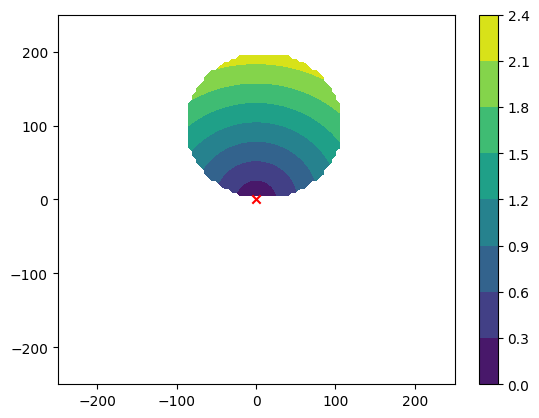

In [5]:
x_mask, y_mask = 100, 10

mask = np.hypot(X_circ-x_mask, Y_circ-y_mask) < 100
cs_circ = np.hypot(u_circ, v_circ)
cs_circ = np.where(mask, cs_circ, np.nan)

plt.contourf(x_circ, y_circ, cs_circ.T)
plt.colorbar()

ui_circ = u_circ[mask]
vi_circ = v_circ[mask]
xi_circ = X_circ[mask]
yi_circ = Y_circ[mask]

x0_circ, y0_circ, q11_circ, q12_circ, q22_circ = moca_space(xi_circ, yi_circ, ui_circ, vi_circ)
print(f"x0: {x0_circ}, y0: {y0_circ}, q11: {q11_circ}, q12: {q12_circ}, q22: {q22_circ}")

plt.scatter(x0_circ, y0_circ, color='r', marker='x')


x0: -5.962985171288479e-15, y0: 2.048221943657061e-15, q11: -0.002, q12: -0.004, q22: -0.002


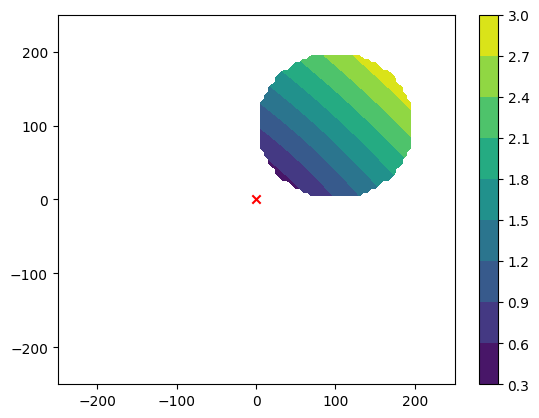

In [6]:
x_mask, y_mask = 100, 100

mask = np.hypot(X_ell-x_mask, Y_ell-y_mask) < 100
cs_ell = np.hypot(u_ell, v_ell)
cs_ell = np.where(mask, cs_ell, np.nan)

plt.contourf(x_ell, y_ell, cs_ell.T)
plt.colorbar()

ui_ell = u_ell[mask]
vi_ell = v_ell[mask]
xi_ell = X_ell[mask]
yi_ell = Y_ell[mask]

x0_ell, y0_ell, q11_ell, q12_ell, q22_ell = moca_space(xi_ell, yi_ell, ui_ell, vi_ell)
print(f"x0: {x0_ell}, y0: {y0_ell}, q11: {q11_ell}, q12: {q12_ell}, q22: {q22_ell}")

plt.scatter(x0_ell, y0_ell, color='r', marker='x')

x0: 1.4240318848916473e-14, y0: -2.2959087756805263e-14, q11: -0.004000000000000001, q12: -0.002000000000000002, q22: -0.0040000000000000036
x0: -5.06365210360995e-14, y0: 3.711795891653979e-13, q11: -0.004000000000000004, q12: -0.0020000000000000026, q22: -0.004000000000000001
x0: -6.857468833813698e-14, y0: 7.824931637753837e-14, q11: -0.004, q12: -0.0020000000000000005, q22: -0.004
x0: 1.1084578345982943e-14, y0: -3.039550783662933e-14, q11: -0.004000000000000001, q12: -0.0020000000000000005, q22: -0.003999999999999999


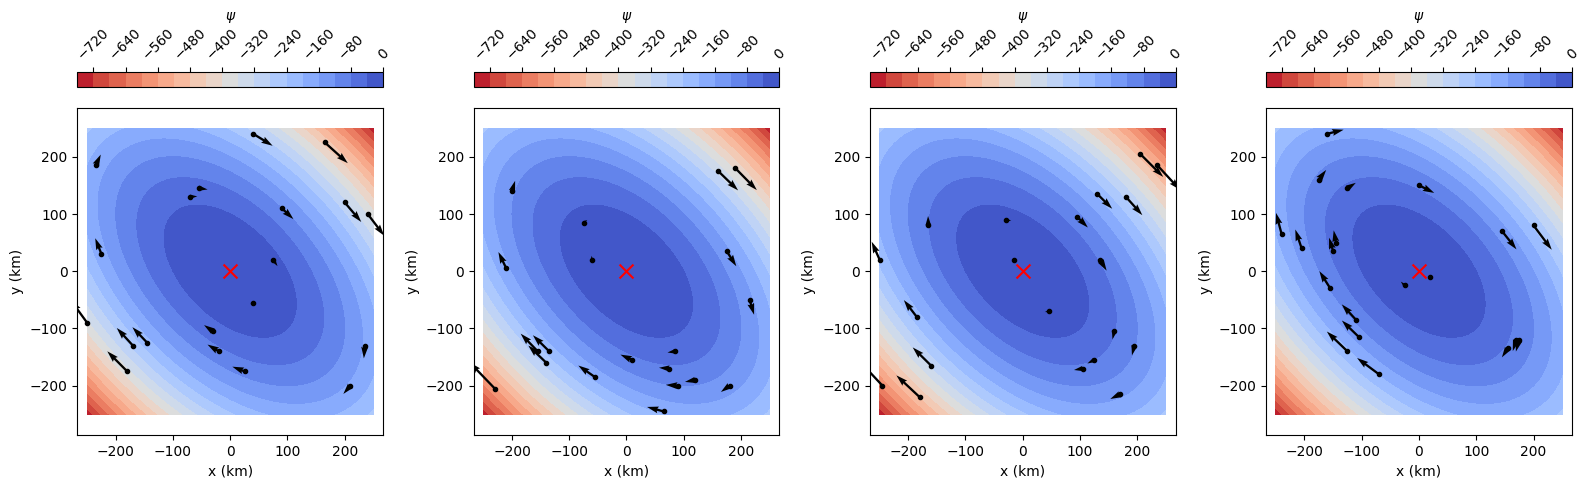

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for ax in axs:
    random_indices = np.random.choice(u_ell.shape[0] * u_ell.shape[1], size=20, replace=False)

    row_indices, col_indices = np.unravel_index(random_indices, u_ell.shape)

    ui = u_ell.T[row_indices, col_indices]
    vi = v_ell.T[row_indices, col_indices]
    xi = X_ell[row_indices, col_indices]
    yi = Y_ell[row_indices, col_indices]

    # cs = np.hypot(u_ell, v_ell)
    c = ax.contourf(x_ell, y_ell, Psi_ell.T, cmap='coolwarm_r', levels=20)

    ax.scatter(xi, yi, color='k', marker='.')
    ax.quiver(xi, yi, ui, vi, color='k')

    x0, y0, q11, q12, q22 = moca_space(xi, yi, ui, vi)
    print(f"x0: {x0}, y0: {y0}, q11: {q11}, q12: {q12}, q22: {q22}")

    ax.scatter(x0, y0, color='r', marker='x', s=100)

    ax.axis('equal')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')


    cbar = fig.colorbar(c, ax=ax, orientation='horizontal', location='top', label=r'$\psi$')
    cbar.ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()



x0: -1.6509359403343892e-13, y0: 1.724829663100999e-13, q11: -0.004000000000000008, q12: -0.0020000000000000065, q22: -0.004000000000000009
x0: -6.306696689157005e-14, y0: -1.3721798180543435e-14, q11: -0.004, q12: -0.0020000000000000013, q22: -0.004000000000000002
x0: 8.289724867183843e-13, y0: -5.613385696802501e-13, q11: -0.003999999999999981, q12: -0.0019999999999999935, q22: -0.004000000000000015
x0: 5.58709345636534e-15, y0: -7.468039091826134e-15, q11: -0.0039999999999999975, q12: -0.0019999999999999987, q22: -0.004000000000000002


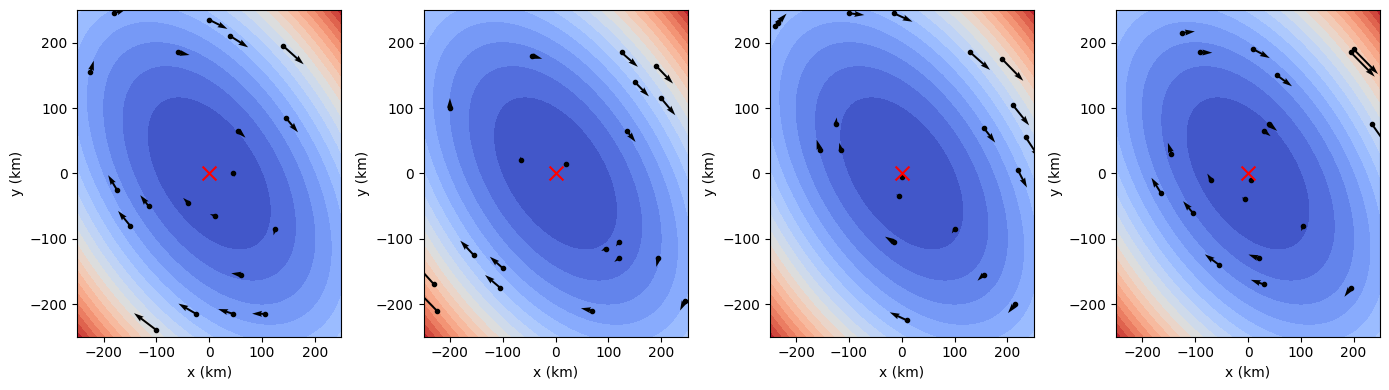

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4))

for ax in axs:
    random_indices = np.random.choice(u_ell.size, size=20, replace=False)
    row_indices, col_indices = np.unravel_index(random_indices, u_ell.shape)

    ui = u_ell.T[row_indices, col_indices]
    vi = v_ell.T[row_indices, col_indices]
    xi = X_ell[row_indices, col_indices]
    yi = Y_ell[row_indices, col_indices]

    c = ax.contourf(x_ell, y_ell, Psi_ell.T, cmap='coolwarm_r', levels=20)
    
    ax.scatter(xi, yi, color='k', marker='.')
    ax.quiver(xi, yi, ui, vi, color='k')

    x0, y0, q11, q12, q22 = moca_space(xi, yi, ui, vi)
    print(f"x0: {x0}, y0: {y0}, q11: {q11}, q12: {q12}, q22: {q22}")

    ax.scatter(x0, y0, color='r', marker='x', s=100)

    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

# fig.colorbar(c, ax=axs, orientation='horizontal', location='top', label=r'\Psi')

plt.tight_layout()
plt.show()


## Modelled Eddy



In [9]:
def calculate_eddy(width=500000, L=1e5, f0=None, alpha_1=0., alpha_2=0., rho0=1025):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = alpha_1 * 0
    y_c = alpha_2 * 0
    r_c = np.hypot(x_2d - x_c, y_2d - y_c)
    
    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u, v, x, y = calculate_eddy()
X, Y = np.meshgrid(x, y)


x0: 13.893373762609812, y0: 34.844360025129994, q11: -0.000712632310415047, q12: -2.5713141900221678e-05, q22: -0.0007171509568353238
x0: 4.198007384427044, y0: -3.0086266370330415, q11: -0.0006461107172944246, q12: 3.817671674854004e-06, q22: -0.0006788921250731499
x0: 17.18436386922685, y0: -19.441004251411222, q11: -0.0007134914882056719, q12: -4.6658230474849586e-05, q22: -0.0007084911264081783
x0: -2.170707887007494, y0: -8.975144985334762, q11: -0.000734514575237406, q12: 5.2716761153540304e-05, q22: -0.0007238241273172255


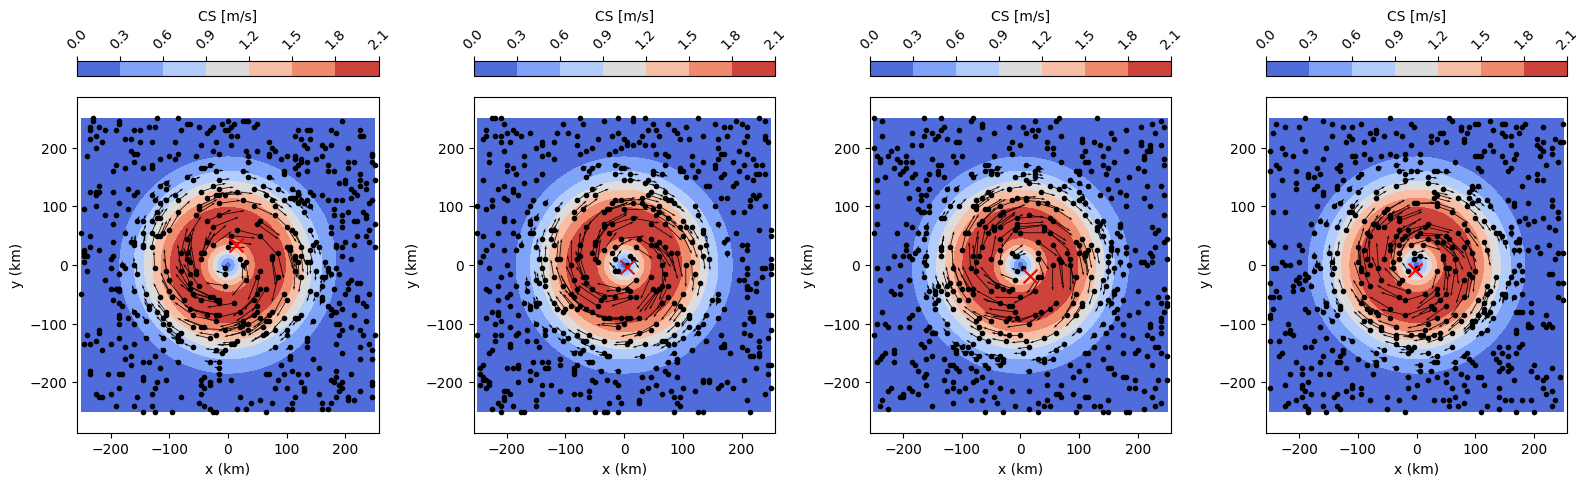

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for ax in axs:
    random_indices = np.random.choice(u_ell.shape[0] * u_ell.shape[1], size=600, replace=False)

    row_indices, col_indices = np.unravel_index(random_indices, u_ell.shape)

    ui = u.T[row_indices, col_indices]
    vi = v.T[row_indices, col_indices]
    xi = X[row_indices, col_indices]
    yi = Y[row_indices, col_indices]

    cs = np.hypot(u, v)
    c = ax.contourf(x_ell, y_ell, cs.T, cmap='coolwarm')

    ax.scatter(xi, yi, color='k', marker='.')
    ax.quiver(xi, yi, ui, vi, color='k')

    x0, y0, q11, q12, q22 = moca_space(xi, yi, ui, vi)
    print(f"x0: {x0}, y0: {y0}, q11: {q11}, q12: {q12}, q22: {q22}")

    ax.scatter(x0, y0, color='r', marker='x', s=100)

    ax.axis('equal')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')


    cbar = fig.colorbar(c, ax=ax, orientation='horizontal', location='top', label='CS [m/s]')
    cbar.ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

x0: -4.904785602797431, y0: 6.799192791149892, q11: -0.012379796039317744, q12: -0.0008567446349462004, q22: -0.012996204837611502
x0: -4.843261892255413, y0: 0.6992955495426482, q11: -0.011469460427477507, q12: 0.0003693859179770626, q22: -0.012338493156891278
x0: 3.9413066189226567, y0: -0.27171567604406593, q11: -0.013141158665953098, q12: 7.311408143087646e-05, q22: -0.014366666077841952
x0: -1.379064244677691, y0: -5.518962065793819, q11: -0.013571099565758462, q12: 0.0005598401619332043, q22: -0.013234105217705816


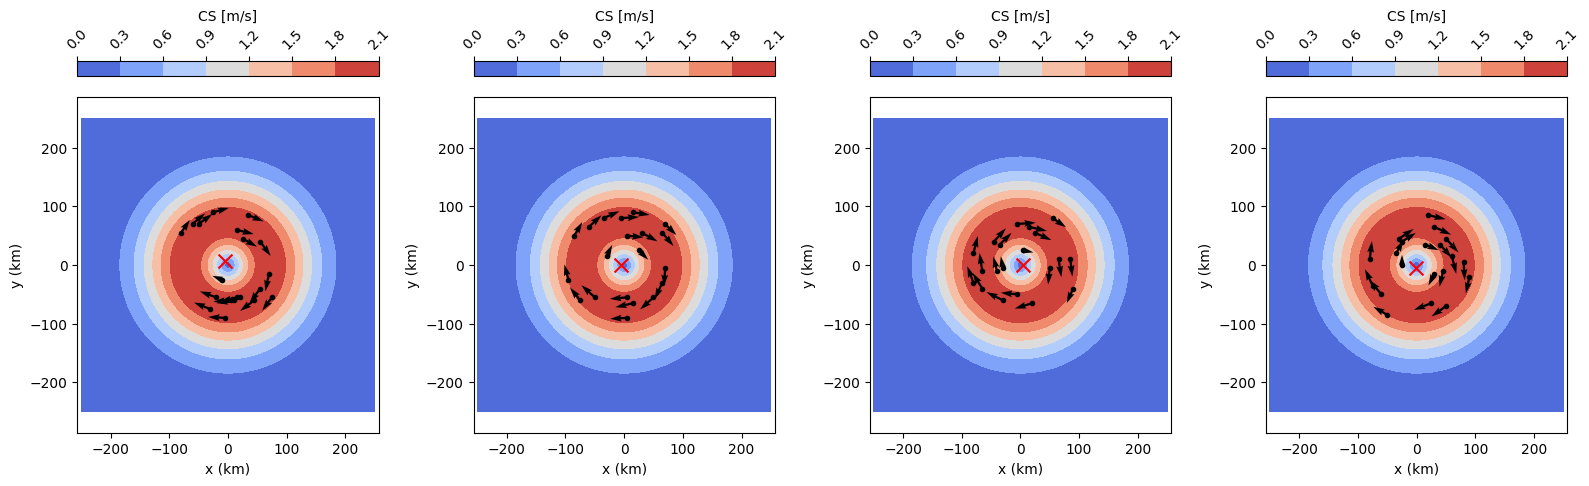

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for ax in axs:
    
    x_search, y_search = 0, 0
    mask = np.hypot(X - x_search, Y - y_search) < 100
    valid_indices = np.argwhere(mask == 1)  # Get row, col indices of valid points

    selected_indices = valid_indices[np.random.choice(valid_indices.shape[0], size=20, replace=False)]

    row_indices, col_indices = selected_indices[:, 0], selected_indices[:, 1]

    ui = u.T[row_indices, col_indices]
    vi = v.T[row_indices, col_indices]
    xi = X[row_indices, col_indices]
    yi = Y[row_indices, col_indices]

    cs = np.hypot(u, v)
    c = ax.contourf(x_ell, y_ell, cs.T, cmap='coolwarm')

    ax.scatter(xi, yi, color='k', marker='.')
    ax.quiver(xi, yi, ui, vi, color='k')

    x0, y0, q11, q12, q22 = moca_space(xi, yi, ui, vi)
    print(f"x0: {x0}, y0: {y0}, q11: {q11}, q12: {q12}, q22: {q22}")

    ax.scatter(x0, y0, color='r', marker='x', s=100)

    ax.axis('equal')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')


    cbar = fig.colorbar(c, ax=ax, orientation='horizontal', location='top', label='CS [m/s]')
    cbar.ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()